### Initialization

Import packages and funcitons

In [1]:
from __future__ import print_function
%precision %.2f
%matplotlib inline
# Interactive widget for plot
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Read in functions.py
import functions
import graphic

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# Plotly
import plotly.express as px
import plotly.graph_objects as go
plt.rcParams["figure.figsize"] = (18, 10)  # plot size

import datetime

# # interactive dataframe
import itables.interactive
from itables import show

# dplyr-style for python
from dppd import dppd
dp, X = dppd()

# display all results from cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings('ignore')

<IPython.core.display.Javascript object>

### Download latest COVID-19 data
Get confirmed / deaths/ recovered number

In [3]:
# Get total timeseries from JHU
global_confirmed = pd.read_csv('https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
global_death = pd.read_csv('https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
global_recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')

global_confirmed = global_confirmed.rename(columns={'Country/Region':'Country'})
global_recovered = global_recovered.rename(columns={'Country/Region':'Country'})
global_death = global_death.rename(columns={'Country/Region':'Country'})

URLError: <urlopen error [Errno 11001] getaddrinfo failed>

### Read inputs

In [4]:
# Proportion of DE is taken from the latest age pyramid: https://www.populationpyramid.net/germany/2019/
AGE_DATA = pd.read_csv("./Data/age_data.csv", index_col="Age Group")
BED_DATA = functions.preprocess_bed_data("./Data/OECD hospital beds.csv")
country_data = pd.read_csv("./Data/OECD demographics.csv")

country_data = (dp(country_data)
               .query("VAR == 'DEMODOMP' & UNIT == 'EFFPEREF' & Year == 2018")
               .mutate(Value = X.Value * 1000)
               .select(["Country","Value"])
               .pd)

### Functions

In [5]:
# Set constant
"""
SIR model constants
"""
class RecoveryRate:
    default = 1 / 10  # Recovery period around 10 days

class MortalityRate:
    # Take weighted average of death rate across age groups. This assumes each age group is equally likely to
    # get infected, which may not be exact, but is an assumption we need to make for further analysis,
    # notably segmenting deaths by age group.
    default = (AGE_DATA.Proportion * AGE_DATA.Mortality).sum()

class CriticalDeathRate:
    # Death rate of critically ill patients who don't have access to a hospital bed.
    # This is the max reported from Wuhan:
    # https://wwwnc.cdc.gov/eid/article/26/6/20-0233_article
    default = 0.122


class TransmissionRatePerContact:
    # Probability of a contact between carrier and susceptible leading to infection.
    # Found using binomial distribution in Wuhan scenario: 14 contacts per day, 10 infectious days, 2.5 average people infected.
    default = 0.018


class AverageDailyContacts:
    min = 0
    max = 50
    default = 15
    
"""
Health care constants
"""

class ReportingRate:
    # Proportion of true cases diagnosed
#     default = 0.14
    default = 1

class HospitalizationRate:
    # Cases requiring hospitalization. We multiply by the ascertainment rate because our source got their estimate
    # from the reported cases, whereas we will be using it with total cases.
    default = 0.19 * ReportingRate.default

'\nSIR model constants\n'

'\nHealth care constants\n'

The crucial factor governing disease spread is R0 (the basic reproduction rate), which is the **average number of people somebody with the disease infects.** This is a function of the number of susceptible people, the infection rate β and the recovery rate γ.

You can decompose this into how many people an infected person contacts a day, and the transmission probability from a given contact:

**β = Probability of transmission x Number of contacts**

We allow you to control **Number of Contacts per day** in the webapp. We have estimated Probability of Transmission from the following numbers:

- **R0**  and **number of infectious days** from [https://github.com/midas-network/COVID-19/tree/master/parameter_estimates/2019_novel_coronavirus](https://github.com/midas-network/COVID-19/tree/master/parameter_estimates/2019_novel_coronavirus), and [https://www.medrxiv.org/content/10.1101/2020.03.05.20030502v1](https://www.medrxiv.org/content/10.1101/2020.03.05.20030502v1)
- **Number of contacts per day** from **Table 1** of [https://www.mdpi.com/2077-0383/9/2/462/htm](https://www.mdpi.com/2077-0383/9/2/462/htm)

We can then formulate R0 as:

**R0 = Probability of transmission x Number of Contacts per day x Number of infectious days**

Subbing in our numbers:

                                  2.5 = Probability of Transmission x 14 x 10

 we solve for Probability of transmission, which comes out as ~0.018, or 1.8%.

**Kermack-McKendrick model assumptions:**

- the population size is fixed (i.e., no births, deaths due to disease, or deaths by natural causes)
- incubation period of the infectious agent is instantaneous
- duration of infectivity is same as length of the disease
- completely homogeneous population with no age, spatial, or social structure

### Simulation

In [6]:
print('Select the country:')
def f_select(Country):
    return(Country)
w_select = interactive(f_select, Country=country_data['Country'])
display(w_select)

Select the country:


interactive(children=(Dropdown(description='Country', options=('Australia', 'Austria', 'Belgium', 'Canada', 'C…

In [8]:
target_country = 'Country == "' + w_select.result + '"'

from datetime import datetime, timedelta
target_date = datetime.strftime(datetime.now(),"%m/%d/%y")
target_date = target_date[-(len(target_date)-1):]

# Test if today's date is already there
try:
    x = global_confirmed[target_date]
    del x
    print('Get the latest data..')
    target_date
except:
    print('Get yesterday data since today is not updated yet..')
    target_date = datetime.strftime(datetime.now()-timedelta(1),"%m/%d/%y")
    target_date = target_date[-(len(target_date)-1):]
    x = global_confirmed[target_date]
    del x
    target_date
    

Get yesterday data since today is not updated yet..


'3/23/20'

In [9]:
historical_df = (dp(global_confirmed)
                 .query(target_country)          
                 .assign(Type = "Confirmed")
                 .append(dp(global_death)
                         .query(target_country)
                         .assign(Type = "Death")
                         .pd)
                 .append(dp(global_recovered)
                         .query(target_country)
                         .assign(Type = "Recovered")
                         .pd)                 
                 .select(["-Province/State",'-Lat','-Long','-Country'])
                 .set_index('Type')
                 .pd)

confirmed = pd.DataFrame(historical_df.iloc[0]).rename_axis('Date').reset_index()
confirmed['Date'] = pd.to_datetime(confirmed['Date']) 
confirmed['Status'] = "Confirmed"
confirmed = confirmed.rename(columns = {'Confirmed':'Number'})

deaths = pd.DataFrame(historical_df.iloc[1]).rename_axis('Date').reset_index()
deaths['Date'] = pd.to_datetime(confirmed['Date']) 
deaths['Status'] = "Deaths"
deaths = deaths.rename(columns = {'Death':'Number'})

recovered = pd.DataFrame(historical_df.iloc[2]).rename_axis('Date').reset_index()
recovered['Date'] = pd.to_datetime(confirmed['Date']) 
recovered['Status'] = "Recovered"
recovered = recovered.rename(columns = {'Recovered':'Number'})

historical_df = confirmed.append(deaths).append(recovered)

In [10]:
num_hospital_beds = (dp(BED_DATA)
                     .query(target_country)
                     .select('Latest Bed Estimate')
                     .pd).iloc[0]['Latest Bed Estimate']

number_cases_deaths =(dp(global_death)
                     .select(['Country',target_date])
                     .query(target_country)
                     .pd).iloc[0][target_date]

number_cases_recovered =(dp(global_recovered)
                     .select(['Country',target_date])
                     .query(target_country)
                     .pd).iloc[0][target_date]

number_cases_confirmed =(dp(global_confirmed)
                     .select(['Country',target_date])
                     .query(target_country)
                     .pd).iloc[0][target_date]

population = (dp(country_data)
             .query(target_country)
             .select('Value')
             .pd).iloc[0]['Value']

#### Get predictions

In [54]:
def f(contact_rate):
    return(contact_rate)

w = interactive(f, contact_rate= widgets.IntSlider(min=0, max=100, step=1, value=50))
print('How many people does an infected individual meet daily?')
display(w)

How many people does an infected individual meet daily?


interactive(children=(IntSlider(value=50, description='contact_rate'), Output()), _dom_classes=('widget-intera…

In [114]:
sir_model = functions.SIRModel(
        transmission_rate_per_contact=TransmissionRatePerContact.default,
        contact_rate = w.result,
        recovery_rate = RecoveryRate.default,
        normal_death_rate = MortalityRate.default,
        critical_death_rate = CriticalDeathRate.default,
        hospitalization_rate = HospitalizationRate.default,
        hospital_capacity = num_hospital_beds,
    )

true_cases_estimator = functions.TrueInfectedCasesModel(ReportingRate.default)
estimated_true_cases = true_cases_estimator.predict(number_cases_confirmed)

df = functions.get_predictions(
    cases_estimator=true_cases_estimator,
    sir_model=sir_model,
    num_diagnosed=number_cases_confirmed,
    num_recovered=number_cases_recovered,
    num_deaths= number_cases_deaths,
    area_population=population)

#### Plotting

In [115]:
print('Historical COVID-19 data of the selected country')
graphic.plot_historical_data(historical_df)


Historical COVID-19 data of the selected country


In [116]:
df_base = df[~df.Status.isin(["Need Hospitalization"])]

df_base['Date'] = None
for idx,row in df_base.iterrows():
    df_base['Date'][idx] = datetime.strftime(datetime.now() + timedelta(int(df_base['Days'][idx])),"%d/%m/%y")
df_base['Date'] = pd.to_datetime(df_base['Date'],format="%d/%m/%y")
graphic.infection_graph(df_base, df_base.Forecast.max())
# graphic.infection_graph(df_base, 2000000)

In [117]:
df_full = (dp(df_base)
           .select("-Days")
           .rename(columns = {'Forecast':'Number'})
           .append(historical_df)
           .pd)
print('Combination historical and forecast COVID-19 cases')
graphic.plot_historical_data(df_full)

Combination historical and forecast COVID-19 cases


In [ ]:
# Work on simulation of 7+ days when social distancing enforced (1.4.2020)



In [80]:
num_dead = df[df.Status == "Dead"].Forecast.iloc[-1]
num_recovered = df[df.Status == "Recovered"].Forecast.iloc[-1]
outcomes_by_age_group = functions.get_status_by_age_group(AGE_DATA, MortalityRate.default,
                                                          num_dead, num_recovered)
fig = graphic.age_segregated_mortality(
    outcomes_by_age_group.loc[:, ["Dead", "Need Hospitalization"]]
)

fig

In [81]:
peak_occupancy = df.loc[df.Status == "Need Hospitalization"]["Forecast"].max()

num_beds_comparison_chart = graphic.num_beds_occupancy_comparison_chart(
    num_beds_available=num_hospital_beds, 
    max_num_beds_needed=peak_occupancy)
num_beds_comparison_chart

### Test zone


In [ ]:
# Get data from today
# from datetime import datetime, timedelta
# try:
#     d = datetime.strftime(datetime.now(),"%m-%d-%Y")
#     url = 'https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports/' + d + '.csv'
#     df = pd.read_csv(url,index_col=0,parse_dates=[0])
# except:
#     # If today's data is not exist --> get yesterday
#     from datetime import datetime, timedelta
#     d = datetime.strftime(datetime.now() - timedelta(1), "%m-%d-%Y")
#     url = 'https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports/' + d + '.csv'
#     df = pd.read_csv(url,index_col=0,parse_dates=[0])


### Germany results
- Population: 82,667,685

**As of 19.03.2020, 09:00 UTC**
- Infected: 12,327
- Recovered: 105
- Dead: 28

**Model**
- True infected: 123,270 (x10 times) (https://www.ncbi.nlm.nih.gov/pubmed/32033064)
#### Case 1 (social distancing ~ 100%-ish)
Everyday infected person meets **3 people**
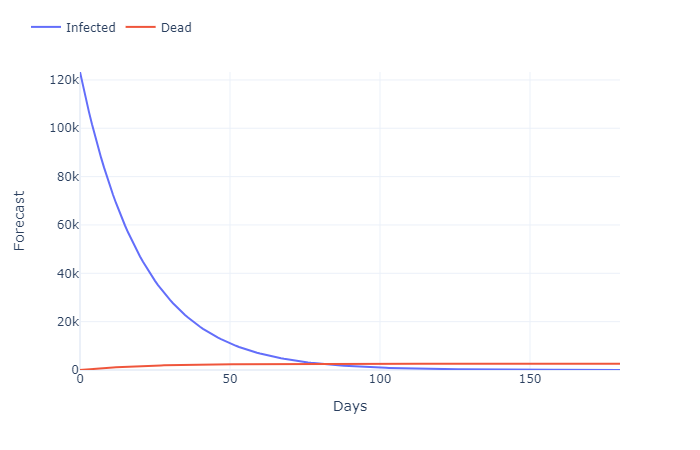

Hospitalization rates (with occupancy)
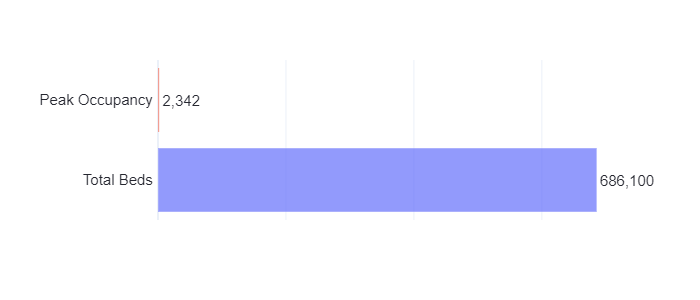

#### Case 2 (partially social distancing)
An infected person meets **20 people** everyday --> infected on avg 2.5 ppl / day
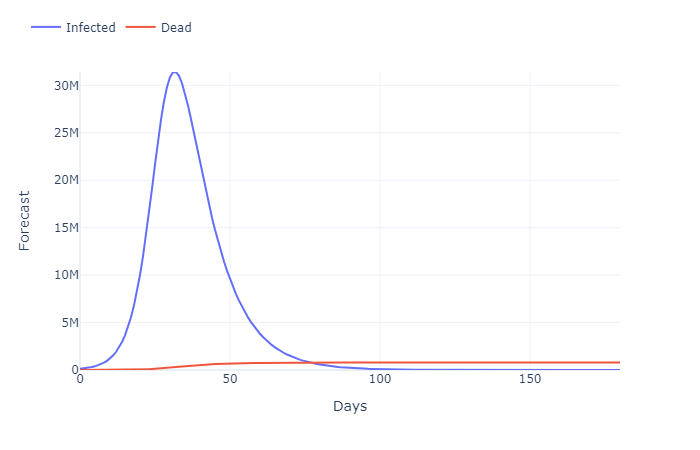

Hospitalization rate:
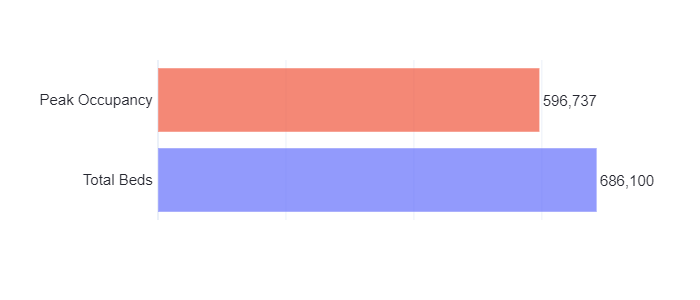

#### Case 3 (not really obey the social distancing rule)
Every day, an infected person meets up with **50 people**
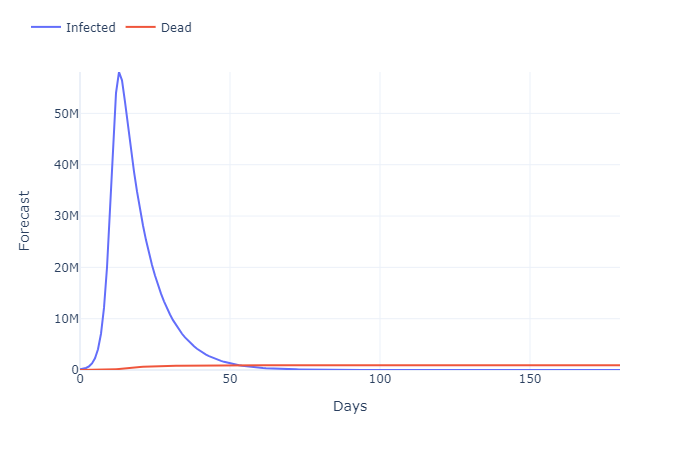

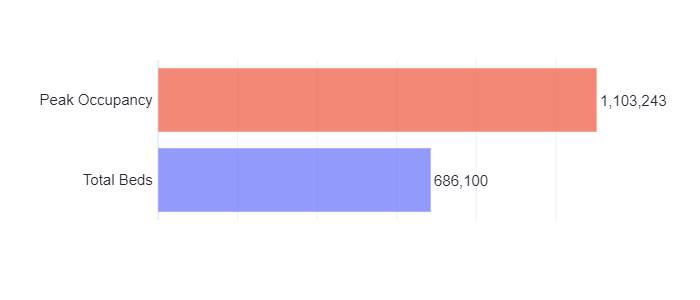

#### Case 4 (ignore social distancing)
Every day, do meet-up with **100 people**
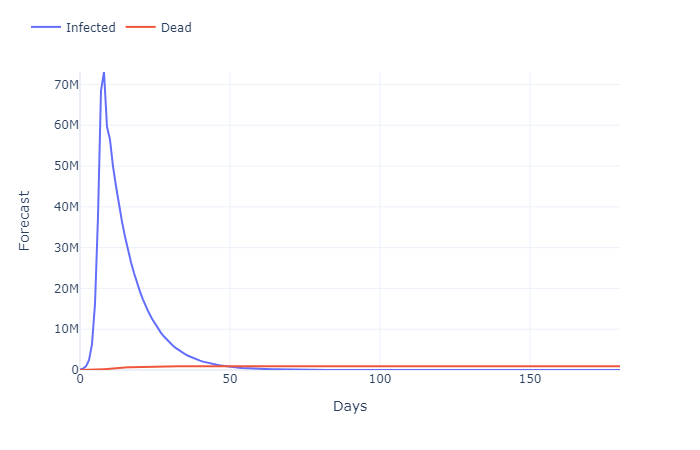

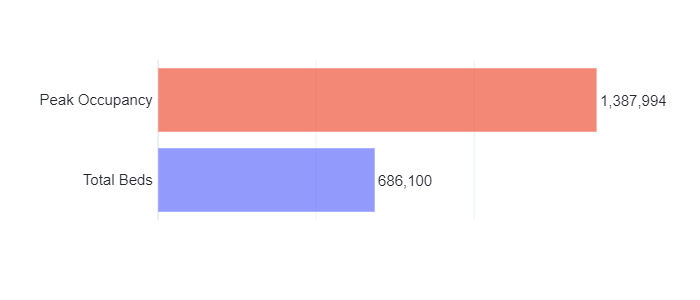
